# Data Analysis 
I will be using this notebook to analyse the data I have recorded, find correllations, and see if my assumptions about the data are correct or not. I would also like to acknowledge here that the process of recording the data was not perfect as the F125's violation system can be inconsistent at times. Another thing to mention is that the region where a driver brakes or hits the throttle are not the only factors that can cause them to crash or violate the track limits, there can be other reasons like the position of their steering, wheel, track conditions, etc. that are not in the scope of this project.

## Assumptions
My assumptions are as follows:

- I believe that the time between the moment a driver hits the brakes and hits the throttle is correllated to the overall lap time. My reasoning is that if the time difference between those inputs is too high, the car is slower for longer.
- I think that the number of times a car brakes is also correllated to the overall lap time. I think this is because the car is slowing down at another point in the lap which may be unneccessary if the driver takes a better racing line with lesser number of braking needed but this may be wrong as sometimes slowing down to take a turn and hitting the apex can be better than forcing the car to turn at a higher speed and missing the apex.
-  

## Exploring the data 
In the code chunk below I have imported all the libraries I require for the data analysis and have loaded the data as well.

In [1]:
# FIRST EDITED: 14/02/2026

import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../Data/collated-data/lap-image-association.csv")

# in the arrays below, s1 means sector 1
s1_num = df["lap_num"].to_numpy()
s1_times = df["s1_time"].to_numpy()
s1_incident = df["incident"].to_numpy()
s1_b_t_deltas = df["brake_throttle_deltas"].to_numpy()
s1_brake_hits = df["related_b_hits"].to_numpy()
s1_throttle_hits = df["related_t_hits"].to_numpy()
#print(df.head)

# LAST EDITED: 14/02/2026

In the code chunk below, I will some plot data.

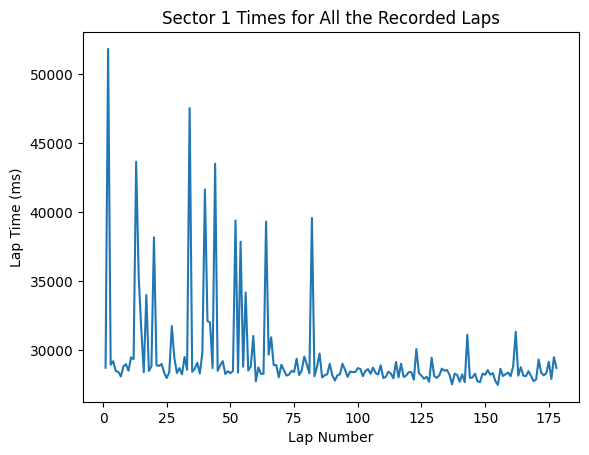

Total laps of data recorded: 178


In [2]:
# FIRST EDITED: 14/02/2026

plt.plot(s1_num, s1_times)
plt.title("Sector 1 Times for All the Recorded Laps")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()

print(f"Total laps of data recorded: {s1_num[-1]}")

# LAST EDITED: 16/02/2026

There seem to be some laps that have very high sector-1 times and that is most probably due to a crash or track limit violation. These incidents result in the car having to get back to the track which takes a while (it should be noted that when I record this data the car is made indestructible to avoid repairs and ensure that all laps have the exact same car). In the code chunk below I will create a data frame without these incidents.

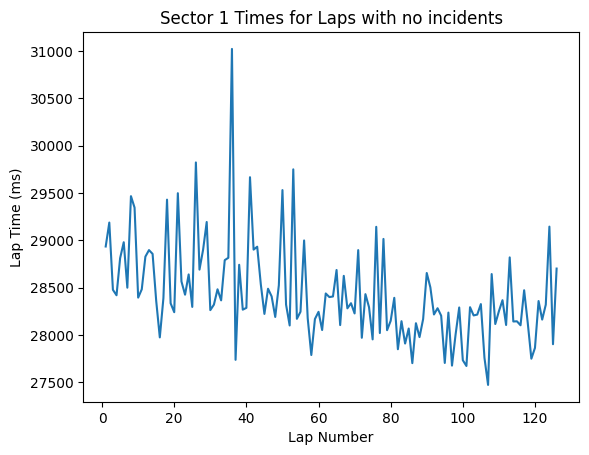

In [3]:
# FIRST EDITED: 14/02/2026

clean_df = df[df['incident'] == 'none']
clean_s1_times = clean_df["s1_time"].to_numpy()

#print(clean_df.head)

# Since the actual lap numbers may create the illusion that the number of laps
# without an incident are the same as the laps with an incident, I am going to use
# a simple range on the y-axis

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with no incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()
#print(clean_s1_times)

# LAST EDITED: 14/02/2026

Perhaps I should exclude laps with a sector-1 time higher than 30000ms. Another thing of note here is that I have improved at driving around the first sector of the lap after 100s of laps which might be why the later laps quicker. In the next code chunk I will remove laps with an unusually long secto-1 time (> 30000ms) and create arrays for the rest of the columns for later use.

Total number of laps recorded without any incident: 125


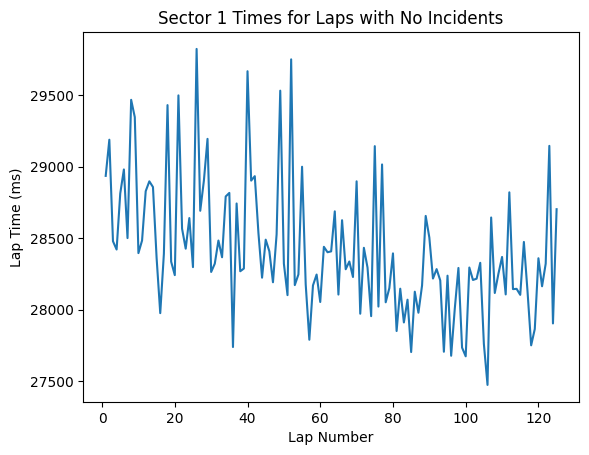

In [4]:
# FIRST EDITED: 14/02/2026

clean_df = clean_df[clean_df['s1_time'] < 30000]

# TODO: Get rid of laps that have more than or less than two screenshots for throttles for incident-less laps and probably delete them too before the cnn training

clean_s1_num = clean_df["lap_num"].to_numpy()
clean_s1_times = clean_df["s1_time"].to_numpy()
clean_s1_b_t_deltas = clean_df["brake_throttle_deltas"].to_numpy()
clean_s1_brake_hits = clean_df["related_b_hits"].to_numpy()
clean_s1_throttle_hits = clean_df["related_t_hits"].to_numpy()

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with No Incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")


print(f"Total number of laps recorded without any incident: {len(pseudo_lap_num)}")
# LAST EDITED: 18/02/2026

Now, without the outlier being present, my assumption about the lap times getting lower as I record more data seems more likely. I may need to find a way to account for this improvement but before doing that I will create three more variables from the cleaned data frame, they are:

- avg_b_t_delta: Average gap between a break and a throttle hit
- brake_hits: Times brakes were hit in sector-1
- throttle_hits: Times throttle as hit in sector-1

I will do so in the following code chunk.

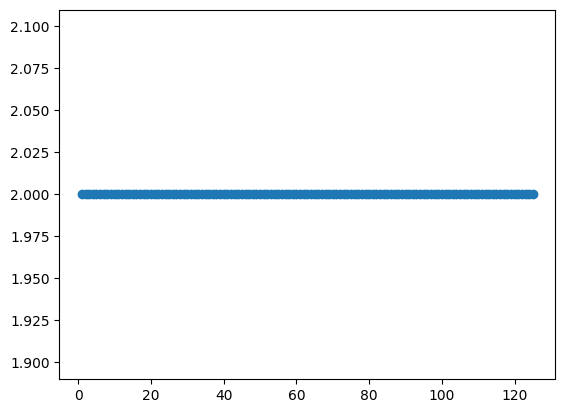

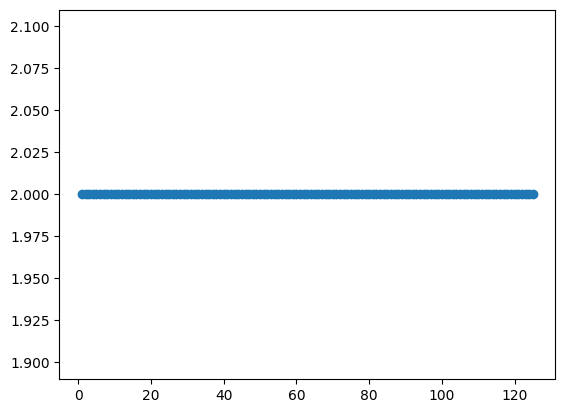

In [5]:
# FIRST EDITED: 14/02/2026

brake_hits = []
throttle_hits = []

for i in range(clean_s1_times.shape[0]):

    brakes = str(clean_s1_brake_hits[0])
    brakes = brakes.split(', ')
    brake_hits.append(len(brakes))

    throttles = str(clean_s1_throttle_hits[0])
    throttles = throttles.split(', ')
    throttle_hits.append(len(throttles))

plt.scatter(pseudo_lap_num, throttle_hits)
plt.show()

plt.scatter(pseudo_lap_num, brake_hits)
plt.show()

# LAST EDITED: 18/02/2026

It is safe to say that there are no laps with more than two brakes or two throttle hits, my assumption about sector-1 having more braking points seems incorrect in the absence of an incident. This finding will help us extract the break-throttle deltas as now I know that there are always going to be two time periods recorded. I will create two separate lists for the brake throttle deltas, one for turn 1 and the other for turn 3.

Since the brake-throttle delta data does not exist for the earlier laps (because I had not originally planned to record that data), I will write the code to extract its data separately below since it requires a bit more nuance compared to brake and throttle hits.

In [9]:
# FIRST EDITED: 14/02/2026

t1_b_t_delta = [] # only recorded from session-6
t2_b_t_delta = [] 

for i in range(clean_s1_times.shape[0]):
    
    #print(type(clean_s1_b_t_deltas[i]))
    if clean_s1_b_t_deltas[i] == '[]':
        t1_b_t_delta.append(0)
        t2_b_t_delta.append(0)
    else:
        # TODO: fix this
        # todo: some laps are missing break delta for turn 3????????
        b_t_d = clean_s1_b_t_deltas[i]
        #b_t_d = str(clean_s1_b_t_deltas[i])
        #b_t_d = b_t_d.split('\', \'')
        #b_t_d = b_t_d[0]
        #b_t_d = list(b_t_d)
        #print(f"Turn 1: {b_t_d[2:18]} and Turn 3: {b_t_d[33:50]} for lap {i+1}")
        print(i+1)
        print(clean_s1_times[i])
        print((b_t_d))

# TODO: Exclude laps with more than 2 or less than 2 throttle hits because that is due to some data collection error, will need to change data cleaning code higher up in the notebook.

# LAST EDITED: 20/02/2026

30
28263
[[1.330505132675171, 1.0, 1.0], [2.5443592071533203, 2.0, 2.0]]
31
28321
[[1.3782010078430176, 1.0, 1.0], [2.5585391521453857, 2.0, 2.0]]
32
28483
[[1.6070523262023926, 1.0, 1.0], [2.64884090423584, 2.0, 2.0]]
33
28366
[[1.4015560150146484, 1.0, 1.0], [2.5156431198120117, 2.0, 2.0]]
34
28791
[[1.4284217357635498, 1.0, 1.0], [2.1875081062316895, 2.0, 2.0]]
35
28816
[[1.6907281875610352, 1.0, 1.0], [1.798781394958496, 2.0, 2.0]]
36
27738
[[1.0230348110198975, 1.0, 1.0], [2.783273696899414, 2.0, 2.0]]
37
28742
[[1.6941251754760742, 1.0, 1.0], [2.6140244007110596, 2.0, 2.0]]
38
28268
[[1.1517844200134277, 1.0, 1.0], [3.0224781036376953, 2.0, 2.0]]
39
28287
[[1.1383581161499023, 1.0, 1.0], [2.626997232437134, 2.0, 2.0]]
40
29667
[[2.2132835388183594, 1.0, 1.0], [2.3482329845428467, 2.0, 2.0]]
41
28902
[[1.325571060180664, 1.0, 1.0], [2.9569568634033203, 2.0, 2.0]]
42
28933
[[1.1870827674865723, 1.0, 1.0], [2.9202165603637695, 2.0, 2.0]]
43
28536
[[1.6241118907928467, 1.0, 1.0], [2.